In [113]:
# Uniform SO(3) sampling in PyTorch + pretty visualizations
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from mpl_toolkits.mplot3d import proj3d

# Euler angles from rotation matrices 
def R2e(R, convention="ZYX"):
    """
    Convert rotation matrices to Euler angles (in radians).

    Args:
        R: array-like [...,3,3] (NumPy or torch)
        convention: rotation order; default 'ZYX' (yaw, pitch, roll)

    Returns:
        eulers: array [...,3] of angles (α, β, γ)
    """
    if torch.is_tensor(R):
        r00, r01, r02 = R[...,0,0], R[...,0,1], R[...,0,2]
        r10, r11, r12 = R[...,1,0], R[...,1,1], R[...,1,2]
        r20, r21, r22 = R[...,2,0], R[...,2,1], R[...,2,2]
    else:
        r00, r01, r02 = R[...,0,0], R[...,0,1], R[...,0,2]
        r10, r11, r12 = R[...,1,0], R[...,1,1], R[...,1,2]
        r20, r21, r22 = R[...,2,0], R[...,2,1], R[...,2,2]

    # ZYX intrinsic (yaw-pitch-roll)
    if convention.upper() == "ZYX":
        sy = torch.sqrt(r00**2 + r10**2) if torch.is_tensor(R) else np.sqrt(r00**2 + r10**2)
        singular = sy < 1e-6

        if torch.is_tensor(R):
            yaw = torch.atan2(r10, r00)
            pitch = torch.atan2(-r20, sy)
            roll = torch.atan2(r21, r22)
            # handle singularities
            yaw = torch.where(singular, torch.atan2(-r01, r11), yaw)
            roll = torch.where(singular, torch.zeros_like(roll), roll)
            return torch.stack([roll, pitch, yaw], dim=-1)
        else:
            yaw = np.arctan2(r10, r00)
            pitch = np.arctan2(-r20, sy)
            roll = np.arctan2(r21, r22)
            yaw = np.where(singular, np.arctan2(-r01, r11), yaw)
            roll = np.where(singular, 0.0, roll)
            return np.stack([roll, pitch, yaw], axis=-1)

    else:
        raise NotImplementedError(f"Convention '{convention}' not supported.")

# axis angle to rotation matrix
def aa2R(axis: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    """axis: (N,3) unit vectors; theta: (N,) radians → R: (N,3,3)"""
    axis = torch.as_tensor(axis)
    theta = torch.as_tensor(theta)
    if axis.ndim == 1:
        axis = axis[None, :]
    if theta.ndim == 0:
        theta = theta[None]
    assert axis.shape[0] == theta.shape[0], "axis and theta batch mismatch"

    kx, ky, kz = axis[:,0], axis[:,1], axis[:,2]
    ct = torch.cos(theta)
    st = torch.sin(theta)
    vt = 1.0 - ct

    r00 = ct + kx*kx*vt
    r01 = kx*ky*vt - kz*st
    r02 = kx*kz*vt + ky*st

    r10 = ky*kx*vt + kz*st
    r11 = ct + ky*ky*vt
    r12 = ky*kz*vt - kx*st

    r20 = kz*kx*vt - ky*st
    r21 = kz*ky*vt + kx*st
    r22 = ct + kz*kz*vt

    R = torch.stack([
        torch.stack([r00, r01, r02], dim=-1),
        torch.stack([r10, r11, r12], dim=-1),
        torch.stack([r20, r21, r22], dim=-1),
    ], dim=-2)
    return R

# quaternion to rotation matrix
def q2R(q):

    qw, qx, qy, qz = q[:,0], q[:,1], q[:,2], q[:,3]
    
    # Convert quaternion (w,x,y,z) to rotation matrices
    ww = qw * qw; xx = qx * qx; yy = qy * qy; zz = qz * qz
    wx = qw * qx; wy = qw * qy; wz = qw * qz
    xy = qx * qy; xz = qx * qz; yz = qy * qz

    r00 = 1.0 - 2.0 * (yy + zz)
    r01 = 2.0 * (xy - wz)
    r02 = 2.0 * (xz + wy)

    r10 = 2.0 * (xy + wz)
    r11 = 1.0 - 2.0 * (xx + zz)
    r12 = 2.0 * (yz - wx)

    r20 = 2.0 * (xz - wy)
    r21 = 2.0 * (yz + wx)
    r22 = 1.0 - 2.0 * (xx + yy)

    R = torch.stack([
        torch.stack([r00, r01, r02], dim=-1),
        torch.stack([r10, r11, r12], dim=-1),
        torch.stack([r20, r21, r22], dim=-1),
    ], dim=-2)  # (n, 3, 3)
    return R

def q2hopf(q: np.ndarray):
    """Quaternion (x,y,z,w) -> Hopf angles (psi in [0,2π), theta in [0,π], phi in [0,2π))."""
    w, x, y, z = q
    psi = 2 * np.arctan2(x, w)
    theta = 2 * np.arctan2(np.sqrt(z**2 + y**2), np.sqrt(w**2 + x**2))
    phi = np.arctan2(z * w - x * y, y * w + x * z)
    # wrap to ranges
    while psi < 0: psi += 2 * np.pi
    while psi >= 2 * np.pi: psi -= 2 * np.pi
    while phi < 0: phi += 2 * np.pi
    while phi >= 2 * np.pi: phi -= 2 * np.pi
    return psi, theta, phi

def hopf2q(psi: torch.Tensor, theta: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """Vectorized Hopf (psi,theta,phi) → quaternion (w,x,y,z) in Torch."""
    # All inputs broadcastable to same shape
    half = 0.5
    cth2 = torch.cos(half * theta)
    sth2 = torch.sin(half * theta)
    cpsi2 = torch.cos(half * psi)
    spsi2 = torch.sin(half * psi)
    w = cth2 * cpsi2
    x = cth2 * spsi2
    y = sth2 * torch.cos(phi + half * psi)
    z = sth2 * torch.sin(phi + half * psi)
    q = torch.stack([w, x, y, z], dim=-1)
    # Normalize for safety
    q = q / torch.linalg.norm(q, dim=-1, keepdim=True).clamp_min(1e-15)
    return q


In [114]:
# Visualization goes here

def _safe_normalize(v, eps=1e-12):
    n = np.linalg.norm(v, axis=-1, keepdims=True)
    return v / np.clip(n, eps, None)


def so3_to_dirs_and_tilt(R, canonical_rotation=None, view_axis="z", tilt_axis="x"):
    ax = {"x": np.array([1,0,0.0]), "y": np.array([0,1,0.0]), "z": np.array([0,0,1.0])}
    e_view = ax[view_axis]; e_tilt = ax[tilt_axis]
    C = np.eye(3) if canonical_rotation is None else canonical_rotation
    RC = R @ C
    v = RC @ e_view
    w = RC @ e_tilt

    # tangent basis at v
    zhat, xhat = ax["z"], ax["x"]
    vhat = _safe_normalize(v)
    helper = np.tile(zhat, (v.shape[0], 1))
    mask = np.abs(vhat @ zhat) > 0.99
    helper[mask] = xhat
    t1 = _safe_normalize(np.cross(helper, vhat))
    t2 = np.cross(vhat, t1)

    wtan = _safe_normalize(w - (np.sum(w * vhat, axis=-1, keepdims=True)) * vhat)
    a = np.sum(wtan * t1, axis=-1)
    b = np.sum(wtan * t2, axis=-1)
    tilt = np.arctan2(b, a)
    hue = (tilt + np.pi) / (2*np.pi)
    return vhat, hue

def _front_mask_from_view(ax3d, pts_xyz):
    """Front hemisphere test from current azim/elev (degrees)."""
    elev = np.deg2rad(ax3d.elev)
    azim = np.deg2rad(ax3d.azim)
    # unit vector pointing from origin towards the camera direction
    n = np.array([np.cos(elev)*np.cos(azim),
                  np.cos(elev)*np.sin(azim),
                  np.sin(elev)])
    # points with positive dot are on the front hemisphere
    return (pts_xyz @ n) > 0.0

def plot_so3_on_sphere_occluding(R, p=None, title="SO(3) on sphere (front points only)",
                                 canonical_rotation=None, view_axis="z", tilt_axis="x",
                                 base_marker_size=180, eps=0.002):
    """
    R: (N,3,3) numpy rotations
    p: (N,) probabilities (optional). Point size ~ base * p * N.
    eps: radial offset so points sit just above the surface (avoid z-fighting).
    """
    N = R.shape[0]
    if p is None:
        p = np.full(N, 1.0/N)

    pts, hue = so3_to_dirs_and_tilt(R, canonical_rotation, view_axis, tilt_axis)
    colors = plt.cm.hsv(hue)
    sizes = base_marker_size * (p * N)

    fig = plt.figure(figsize=(7.2, 7.2))
    ax = fig.add_subplot(111, projection="3d")

    # Sphere mesh (opaque, acts as occluder)
    u = np.linspace(0, 2*np.pi, 160)
    v = np.linspace(0, np.pi, 80)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(xs, ys, zs, rstride=1, cstride=1,
                    linewidth=0.0, antialiased=True, shade=True,
                    color="#E6E6E6", alpha=1.0, zorder=1)

    # Decide front after axes are set (uses current azim/elev)
    front = _front_mask_from_view(ax, pts)

    # Lift points slightly above radius 1 to prevent z-fighting
    pts_front = (1.0 + eps) * pts[front]

    ax.scatter(pts_front[:,0], pts_front[:,1], pts_front[:,2],
               s=sizes[front], c=colors[front],
               alpha=0.95, linewidths=0.0, depthshade=False, zorder=2)

    ax.set_box_aspect([1,1,1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.set_title(title)
    fig.tight_layout()
    return fig



def so3_to_mollweide_and_tilt(
    R,                      # (N,3,3) numpy
    canonical_rotation=None,# (3,3) numpy or None
    view_axis="z",          # 'x'|'y'|'z' body axis for position
    tilt_axis="x",          # 'x'|'y'|'z' body axis for color
    use_standard_lonlat=True
):
    ax = {"x": np.array([1,0,0.0]), "y": np.array([0,1,0.0]), "z": np.array([0,0,1.0])}
    e_view = ax[view_axis]
    e_tilt = ax[tilt_axis]

    C = np.eye(3) if canonical_rotation is None else canonical_rotation
    RC = R @ C  # (N,3,3)

    v = RC @ e_view  # (N,3)
    w = RC @ e_tilt  # (N,3)

    # Tangent basis at v
    v_hat = _safe_normalize(v)
    zhat = ax["z"]; xhat = ax["x"]
    mask_polar = np.abs(v_hat @ zhat) > 0.99
    helper = np.tile(zhat, (v.shape[0], 1))
    helper[mask_polar] = xhat

    t1 = _safe_normalize(np.cross(helper, v_hat))
    t2 = np.cross(v_hat, t1)

    # Project w to tangent plane and compute tilt
    w_tan = _safe_normalize(w - (np.sum(w * v_hat, axis=-1, keepdims=True)) * v_hat)
    a = np.sum(w_tan * t1, axis=-1)
    b = np.sum(w_tan * t2, axis=-1)
    tilt = np.arctan2(b, a)  # (-pi,pi]

    # Long/lat
    if use_standard_lonlat:
        lon = np.arctan2(v[:,1], v[:,0])                # [-pi,pi]
        lat = np.arcsin(np.clip(v[:,2], -1.0, 1.0))     # [-pi/2,pi/2]
    else:
        # Your earlier alternative; use consistently if you switch
        lon = np.arctan2(v[:,0], -v[:,1])
        lat = np.arcsin(np.clip(v[:,2], -1.0, 1.0))

    # Hue
    hue = (tilt + np.pi) / (2.0 * np.pi)                # [0,1)
    return lon, lat, tilt, hue

def add_tilt_wheel(fig, gridspec_cell, cmap):
    axw = fig.add_subplot(gridspec_cell, projection='polar')
    theta_edges = np.linspace(0.0, 2.0*np.pi, 361)
    radii_edges = np.array([0.40, 0.56])
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    hue_centers = theta_centers / (2.0 * np.pi)
    C = hue_centers[:, None]  # (360,1)
    axw.pcolormesh(theta_edges, radii_edges, C.T, cmap=cmap, shading='auto')
    axw.set_rmin(radii_edges[0]); axw.set_rmax(radii_edges[1])
    axw.set_yticklabels([])
    axw.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    axw.set_xticklabels([r'$0^\circ$', r'$90^\circ$', r'$180^\circ$',
                         r'$-90^\circ$', r'$-180^\circ$'], fontsize=9)
    axw.spines['polar'].set_visible(False)
    axw.set_title("tilt", va='bottom', fontsize=10, pad=15)
    return axw

def visualize_mollewide(R, p):
    lon, lat, tilt, hue = so3_to_mollweide_and_tilt(
    R,
    canonical_rotation=None,   # or e.g. Rz(np.pi/4) for a rotated view
    view_axis="z",             # which body axis maps to the sphere
    tilt_axis="x",             # which body axis defines the color spin
    use_standard_lonlat=True   # keep consistent across samplers
    )

    # -------------------------------------------------------------------------
    # 3. Plot Mollweide map + external tilt color wheel
    # -------------------------------------------------------------------------
    cmap = plt.cm.hsv
    fig = plt.figure(figsize=(10.5, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[10, 2], wspace=0.05)
    
    # Scatter on Mollweide projection
    ax = fig.add_subplot(gs[0, 0], projection='mollweide')
    #ax.scatter(lon, lat, s=6*p*R.shape[0], c=cmap(hue),
    #           alpha=0.9, linewidths=0.0)
    
    scatterpoint_scaling = 4e3
    
    # Display the distribution
    ax.scatter(lon, lat, s=scatterpoint_scaling * p, c=cmap(hue))

    ax.grid(True, linestyle='-', linewidth=0.8)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title("Consistent Mollweide view of SO(3) samples", pad=14)
    
    # Add polar tilt color wheel outside (uses the same hue mapping)
    add_tilt_wheel(fig, gs[0, 1], cmap)
    
    fig.tight_layout()    

In [132]:
# Sampling methods

# Shoemake (1992)
def sample_uniform_shomake(n: int, device: str = "cpu", dtype: torch.dtype = torch.float32) -> torch.Tensor:
    """
    Shoemake (1992) method via uniform unit quaternions.
    Returns rotation matrices of shape (n, 3, 3) in PyTorch.
    """
    u1 = torch.rand(n, device=device, dtype=dtype)
    u2 = torch.rand(n, device=device, dtype=dtype)
    u3 = torch.rand(n, device=device, dtype=dtype)

    sqrt1_u1 = torch.sqrt(1.0 - u1)
    sqrt_u1   = torch.sqrt(u1)
    theta1 = 2.0 * math.pi * u2
    theta2 = 2.0 * math.pi * u3

    # Quaternion components (x, y, z, w)
    qx = sqrt1_u1 * torch.sin(theta1)
    qy = sqrt1_u1 * torch.cos(theta1)
    qz = sqrt_u1   * torch.sin(theta2)
    qw = sqrt_u1   * torch.cos(theta2)

    # Normalize for numerical safety
    norm = torch.linalg.norm(torch.stack([qw, qx, qy, qz], dim=-1), dim=-1, keepdim=True)
    qw, qx, qy, qz = (t / norm.squeeze(-1) for t in (qw, qx, qy, qz))

    return q2R([qw,qx,qy,qz])

# Uniform over sphere
def sample_so3_haar(n: int, device="cpu", dtype=torch.float64):
    """
    Haar-uniform sampling on SO(3) via uniform S^3 quaternions.
    Draw q ~ N(0,I_4), normalize (uniform on S^3), map to rotation.
    Returns (n,3,3).
    """
    q = torch.randn(n, 4, device=device, dtype=dtype)
    q = q / q.norm(dim=-1, keepdim=True)
    return q2R(q)

# HEALPIX

# ---------- Helper: Haar(SO(3)) angle midpoints (deterministic) ----------
# Haar angle θ ∈ [0, π] has CDF F(θ) = (θ - sin θ)/π.
# We invert F at equally spaced midpoints u_k = (k+0.5)/K to get θ_k.
def _inverse_cdf_haar_theta(u: torch.Tensor, tol=1e-12, max_iter=64) -> torch.Tensor:
    u = torch.clamp(u, 0.0, 1.0)
    th = torch.pi * u  # good initial guess
    for _ in range(max_iter):
        f  = (th - torch.sin(th)) / torch.pi - u           # F(th) - u
        df = (1.0 - torch.cos(th)) / torch.pi              # F'(th)
        step = f / torch.clamp(df, min=1e-15)
        th_new = th - step
        if torch.max(torch.abs(th_new - th)) < tol:
            th = th_new
            break
        th = th_new
    return torch.clamp(th, 0.0, torch.pi)

# ---------- Deterministic HEALPix axes on S² ----------
def healpix_axes(resol: int, device="cpu", dtype=torch.float64) -> torch.Tensor:
    """
    Return S² unit vectors at HEALPix pixel centers (equal-area), nside = 2**resol.
    Deterministic; no randomness.
    """
    nside = 2 ** int(resol)
    npix = 12 * nside * nside
    theta_np, phi_np = hp.pix2ang(nside, range(npix), nest=True)  # θ∈[0,π], φ∈[0,2π)
    theta = torch.as_tensor(theta_np, device=device, dtype=dtype)
    phi   = torch.as_tensor(phi_np,   device=device, dtype=dtype)
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    axes = torch.stack([x, y, z], dim=-1)  # (Npix,3)
    return axes

# ---------- Deterministic SO(3) grid: HEALPix axes × Haar-angle midpoints ----------
def sample_so3_healpix(resol: int, nangles: int, device="cpu", dtype=torch.float64) -> torch.Tensor:
    """
    Deterministic low-dispersion SO(3) grid (no randomness):
      - Axes = HEALPix pixel centers (equal-area on S²).
      - Angles θ_k = F^{-1}((k+0.5)/nangles) (equal-mass midpoints under Haar).
    Returns: R with shape (Npix * nangles, 3, 3).
    """
    axes = healpix_axes(resol, device=device, dtype=dtype)  # (Npix,3)
    Npix = axes.shape[0]
    u = (torch.arange(nangles, device=device, dtype=dtype) + 0.5) / nangles
    theta = _inverse_cdf_haar_theta(u)                      # (nangles,)
    axes_rep  = axes.repeat_interleave(nangles, dim=0)      # (Npix*nangles, 3)
    theta_rep = theta.repeat(Npix)                          # (Npix*nangles,)
    return aa2R(axes_rep, theta_rep)
# HEALPIX ends

def sample_so3_healpix_equimass(nside: int, nangles: int,
                                device="cpu", dtype=torch.float64,
                                nest: bool=True) -> torch.Tensor:
    """
    Deterministic equal-Haar grid on SO(3):
      - axes: HEALPix pixel centers (equal area on S^2)
      - angles: equal-mass midpoints under Haar f(θ)=(1/π)(1−cos θ)
    Returns R: (12*nside^2 * nangles, 3, 3)
    """
    npix = 12 * nside * nside
    ipix = torch.arange(npix, device=device)
    theta_np, phi_np = hp.pix2ang(nside, ipix.cpu().numpy(), nest=nest)
    theta = torch.tensor(theta_np, device=device, dtype=dtype)
    phi   = torch.tensor(phi_np,   device=device, dtype=dtype)
    axes = torch.stack([torch.sin(theta)*torch.cos(phi),
                        torch.sin(theta)*torch.sin(phi),
                        torch.cos(theta)], dim=-1)  # (npix,3)

    # equal-mass midpoints in θ
    u = (torch.arange(nangles, device=device, dtype=dtype) + 0.5) / nangles
    thetas = _inverse_cdf_haar_theta(u)  # (nangles,)

    # Cartesian product
    axes_rep  = axes.repeat_interleave(nangles, dim=0)   # (npix*nangles,3)
    theta_rep = thetas.repeat(npix)                      # (npix*nangles,)
    return aa2R(axes_rep, theta_rep)

def sample_so3_healpix_equimass_N(N: int, device="cpu", dtype=torch.float64, nest: bool=True):
    """
    Convenience: pick (nside, nangles) so npix*nangles is close to N,
    then build the equal-mass grid.
    """
    # crude search over nside (powers of 2 are typical, but any nside works)
    best = None
    for nside in [1, 2, 4, 8, 16, 32, 64]:
        npix = 12*nside*nside
        nangles = max(1, round(N/npix))
        total = npix*nangles
        err = abs(total - N)
        if (best is None) or (err < best[0]):
            best = (err, nside, nangles, total)
    _, nside, nangles, total = best
    R = sample_so3_healpix_equimass(nside, nangles, device=device, dtype=dtype, nest=nest)
    # If total > N, optionally truncate to exactly N:
    if total > N:
        R = R[:N]
    return R
    
# Yershova's Hopf fibration begins
def grid_s1(resol: int, device="cpu", dtype: torch.dtype = torch.float64) -> torch.Tensor:
    """Equi-spaced S^1 centers for the fiber psi in [0, 2π)."""
    points = 6 * (2 ** int(resol))
    # torch.linspace with endpoint=False, then shift by half-cell
    points = 6 * (2 ** int(resol))
    # PyTorch linspace can't do endpoint=False → emulate
    psi = torch.linspace(0.0, 2 * torch.pi, steps=points + 1, device=device, dtype=dtype)[:-1]
    psi = psi + (torch.pi / points)     # center of bins
    return psi

def grid_s2_healpix(resol: int, device="cpu", dtype: torch.dtype = torch.float64):
    """HEALPix centers (theta in [0,π], phi in [0,2π)) for S^2 base (nest ordering)."""
    nside = 2 ** int(resol)
    npix = 12 * nside * nside
    theta_np, phi_np = hp.pix2ang(nside, range(npix), nest=True)  # theta, phi as numpy arrays
    theta = torch.as_tensor(theta_np, device=device, dtype=dtype)
    phi = torch.as_tensor(phi_np, device=device, dtype=dtype)
    return theta, phi

def num_cells(resol: int) -> int:
    """Total number of grid cells on SO(3)."""
    s1_len = 6 * (2 ** int(resol))
    s2_len = 12 * (2 ** (2*int(resol)))
    return s1_len * s2_len

def sample_so3_hopf(resol: int, device="cpu", dtype: torch.dtype = torch.float64) -> torch.Tensor:
    """
    Deterministic low-dispersion set of rotations on SO(3) (shape (N,3,3)),
    built via Hopf fibration: HEALPix on S^2 (theta,phi) × equi-spaced S^1 fiber (psi).
    Quaternions are returned internally in (w,x,y,z) convention; output is rotation matrices.
    """
    psi = grid_s1(resol, device=device, dtype=dtype)                    # (S1,)
    theta, phi = grid_s2_healpix(resol, device=device, dtype=dtype)     # (S2,), (S2,)

    # Cartesian product without leaving torch
    S1, S2 = psi.shape[0], theta.shape[0]
    psi_rep = psi[:, None].expand(S1, S2).reshape(-1)       # (S1*S2,)
    theta_rep = theta[None, :].expand(S1, S2).reshape(-1)   # (S1*S2,)
    phi_rep = phi[None, :].expand(S1, S2).reshape(-1)       # (S1*S2,)

    q = hopf2q(psi_rep, theta_rep, phi_rep) # (N,4)
    R = q2R(q)                         # (N,3,3)
    return R
# Yershova ends


# Marc's Super Fibonacci Spirals (2022)

# Marc Alexa's constants from the reference code
SN  = 1.533751168755204288118041
IPHI = 1.0 / (2.0 ** 0.5)          # 1/sqrt(2)
IPSI = 1.0 / SN                    # ~0.65270364

def super_fibonacci_quaternions(n: int,
                            mc0: float = IPHI,
                            mc1: float = IPSI,
                            device: str = "cpu",
                            dtype: torch.dtype = torch.float64,
                        ) -> torch.Tensor:
    """
    Marc Alexa's Super-Fibonacci sequence on SO(3) as unit quaternions, matching his code.
    Returns q as (w,x,y,z) with shape (n,4).
    """
    i = torch.arange(n, device=device, dtype=dtype)
    s = i + 0.5
    ab = 2.0 * torch.pi * s
    theta = ab * mc0
    phi   = ab * mc1

    s = s / n
    r = torch.sqrt(s)
    R = torch.sqrt(1.0 - s)

    # Marc's code constructs (x, y, z, w) as below:
    x = r * torch.sin(theta)
    y = r * torch.cos(theta)
    z = R * torch.sin(phi)
    w = R * torch.cos(phi)

    # Return (w,x,y,z) for downstream consistency
    q = torch.stack([w, x, y, z], dim=-1)
    # Normalize for numerical safety (should already be on S^3)
    q = q / torch.linalg.norm(q, dim=-1, keepdim=True).clamp_min(1e-15)
    return q

def sample_so3_super_fib(
                        n: int,
                        mc0: float = IPHI,
                        mc1: float = IPSI,
                        device: str = "cpu",
                        dtype: torch.dtype = torch.float64,
                    ) -> torch.Tensor:
    """
    Rotation matrices (n,3,3) from Marc Alexa's super-fibonacci sampler.
    """
    q = super_fibonacci_quaternions(n, mc0=mc0, mc1=mc1, device=device, dtype=dtype)
    return q2R(q)



# Representation (Wigner) theoretic sampling begins

# ---------- helpers ----------
def _rz(a):
    ca, sa = torch.cos(a), torch.sin(a)
    R = torch.zeros(a.shape + (3,3), dtype=a.dtype, device=a.device)
    R[...,0,0], R[...,0,1] =  ca, -sa
    R[...,1,0], R[...,1,1] =  sa,  ca
    R[...,2,2] = 1.0
    return R

def _ry(b):
    cb, sb = torch.cos(b), torch.sin(b)
    R = torch.zeros(b.shape + (3,3), dtype=b.dtype, device=b.device)
    R[...,0,0], R[...,0,2] =  cb,  sb
    R[...,1,1] = 1.0
    R[...,2,0], R[...,2,2] = -sb,  cb
    return R

def _gauss_legendre_nodes_weights(n, device="cpu", dtype=torch.float64):
    # via numpy (stable & deterministic), then cast to torch
    x, w = np.polynomial.legendre.leggauss(n)  # x in [-1,1], w>0
    x = torch.tensor(x, device=device, dtype=dtype)
    w = torch.tensor(w, device=device, dtype=dtype)
    return x, w

def sample_so3_wigner_gauss(L: int,
                          device="cpu",
                          dtype=torch.float64,
                          scramble=True,
                          sigma_alpha: int = 1,
                          sigma_gamma: int = 3) -> torch.Tensor:
    """
    Deterministic SO(3) grid for band-limit L (exact for |m|,|n|,ℓ ≤ L-1):
      - α,γ: equiangular with 2L samples each
      - β: Gauss–Legendre with 2L nodes mapped by β=arccos(x)
    Optional 'scramble' applies β-dependent cyclic shifts in α,γ (preserves exactness)
    to remove visible banding. Returns R: (N,3,3) with N = 8 L^3.
    """
    assert L >= 1
    twoL = 2 * L

    # α, γ equiangular grids (no endpoint argument)
    a = torch.arange(twoL, device=device, dtype=dtype) * (2 * torch.pi / twoL)
    g = torch.arange(twoL, device=device, dtype=dtype) * (2 * torch.pi / twoL)

    # β from Gauss–Legendre on x = cos β
    x, w = _gauss_legendre_nodes_weights(twoL, device=device, dtype=dtype)
    x = torch.clamp(x, -1.0, 1.0)
    b = torch.arccos(x)  # (2L,)

    # optional deterministic β-dependent cyclic shifts to decorrelate rings
    if scramble:
        k = torch.arange(twoL, device=device)
        shift_a = (sigma_alpha * k) % twoL
        shift_g = (sigma_gamma * k) % twoL
        a_grid = a[(torch.arange(twoL, device=device)[:, None] + shift_a[None, :]) % twoL]
        g_grid = g[(torch.arange(twoL, device=device)[:, None] + shift_g[None, :]) % twoL]
    else:
        a_grid = a[None, :].repeat(twoL, 1)
        g_grid = g[None, :].repeat(twoL, 1)

    # expand β over (α,γ) grid
    b_grid = b[:, None, None].expand(twoL, twoL, twoL)
    a_grid = a_grid[:, :, None].expand(twoL, twoL, twoL)
    g_grid = g_grid[:, None, :].expand(twoL, twoL, twoL)

    # build rotations Rz(a) Ry(b) Rz(g)
    R = _rz(a_grid) @ _ry(b_grid) @ _rz(g_grid)
    R = R.reshape(-1, 3, 3)
    return R


def sample_so3_wigner_gauss_N(N: int, device="cpu", dtype=torch.float64,
                             scramble=True, sigma_alpha=1, sigma_gamma=3) -> torch.Tensor:
    """
    Pick L so that 8 L^3 is closest to N, then return the Wigner–Gauss grid.
    """
    # closed form nearest integer to (N/8)^(1/3)
    L = max(1, int(round((N / 8.0) ** (1.0 / 3.0))))
    R = sample_so3_wigner_gauss(L, device=device, dtype=dtype,
                              scramble=scramble, sigma_alpha=sigma_alpha, sigma_gamma=sigma_gamma)
    # if overshoot, truncate deterministically
    if R.shape[0] > N:
        R = R[:N]
    return R
# Representation (Wigner) theoretic sampling ends

(4096, 3, 3)


/var/folders/tn/l1w254bs46v25y2syzllpgmm0000gn/T/ipykernel_76216/2494406542.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


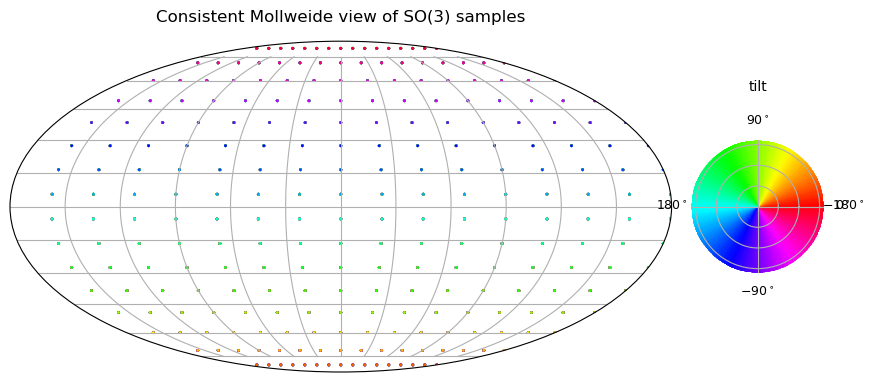

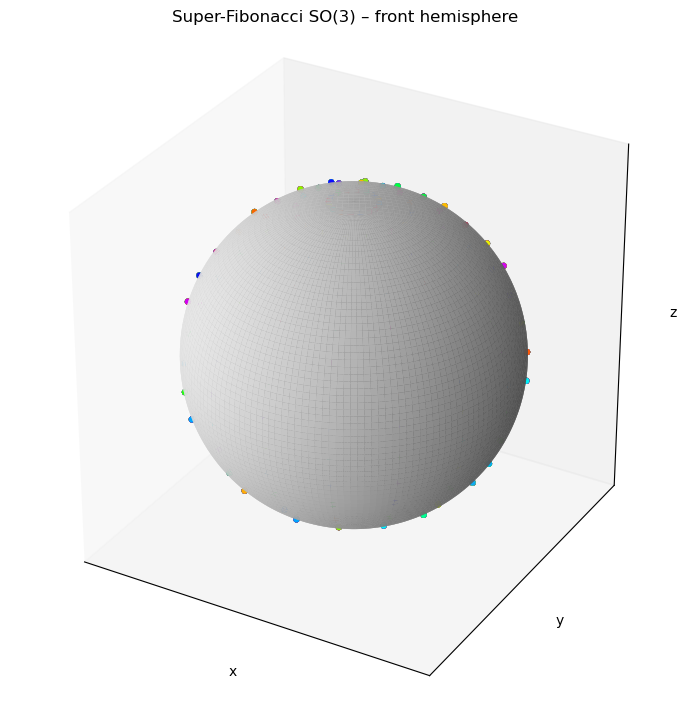

/var/folders/tn/l1w254bs46v25y2syzllpgmm0000gn/T/ipykernel_76216/987737713.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2d.tight_layout()


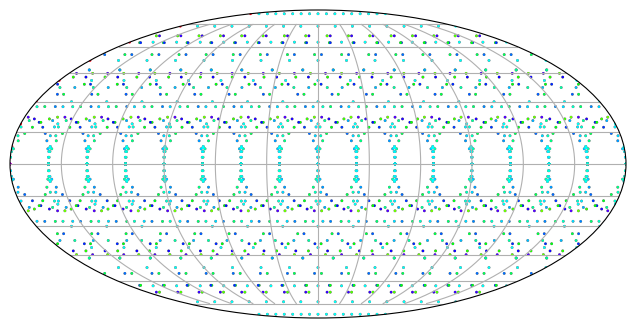

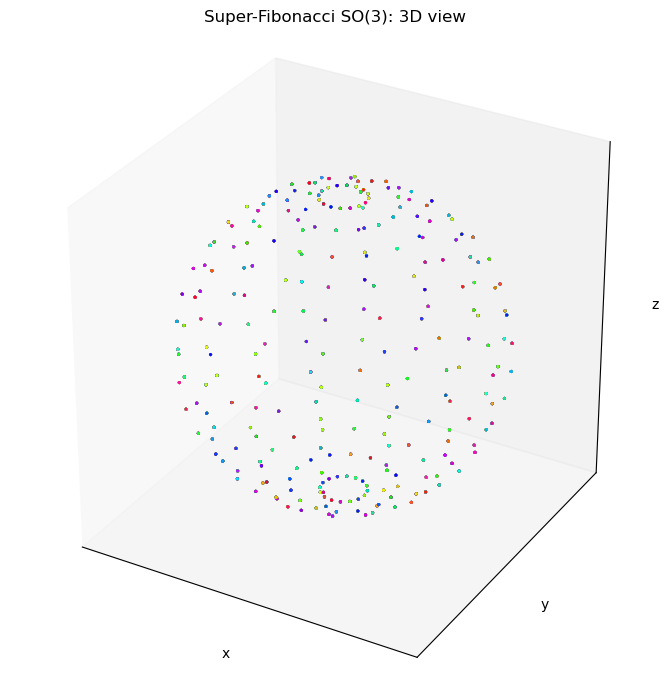

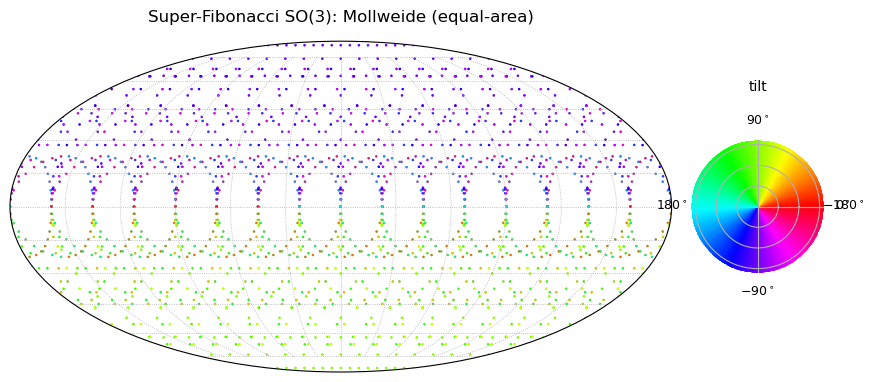

In [133]:
# (optional) a canonical display rotation
canonical_rotation = np.eye(3)

# Actual sampling: output is (N,3,3)
#R_torch = sample_so3_haar(500, dtype=torch.float64)
#R_torch = sample_uniform_shomake(100, dtype=torch.float64)
#R_torch = sample_so3_healpix(resol=2, nangles=8, device="cpu", dtype=torch.float32)
#R_torch =sample_so3_healpix_equimass_N(N=5000)
#R_torch = sample_so3_hopf(resol=2, device="cpu", dtype=torch.float32)
#R_torch = sample_so3_super_fib(1000, device="cpu", dtype=torch.float64) 
# Deterministic, visually uniform grid from Wigner-D harmonics sampling theorem
R_torch = sample_so3_wigner_gauss(L=8, device="cpu", dtype=torch.float64, scramble=True)

R = R_torch.detach().cpu().numpy()
print(R.shape)

# Choose probabilities (uniform here) for all methods
p = np.full(R.shape[0], 1.0 / R.shape[0])

visualize_mollewide(R, p)

fig3d = plot_so3_on_sphere_occluding(
    R, p,
    title="Super-Fibonacci SO(3) – front hemisphere",
    canonical_rotation=None,   # or a 3x3 if you want to rotate the globe
    view_axis="z",             # sphere position = R e_z
    tilt_axis="x",             # color tilt from R e_x
    base_marker_size=20,      # smaller clean dots
    eps=0.002                  # tiny lift above surface
)

plt.show()

# plot
fig = visualize_so3_probabilities(
    rotations=R,
    probabilities=p,
    display_threshold_probability=0,
    to_image=False,                 # set True only if you implemented plot_to_image
    show_color_wheel=False,
    canonical_rotation=canonical_rotation
)
#plt.show()

#fig1, fig2 = plot_so3_points_on_s2(R, p)
#fig1, fig2 = plot_tilt_colored_so3(R, p, title_prefix="Super-Fibonacci SO(3)")
# 3. Call the visualization function
fig3d, fig2d = plot_tilt_colored_so3(
    R,
    p,
    title_prefix="Super-Fibonacci SO(3)",
    show_color_wheel=True,
    base_marker_size_3d=5,    # smaller, cleaner dots
    base_marker_size_2d=3
)

plt.show()